In [3]:
%pip install pandas numpy matplotlib scikit-learn


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.0 MB 8.4 MB/s eta 0:00:02
   ------------ --------------------------- 3.4/11.0 MB 9.2 MB/s eta 0:00:01
   -------------------- ------------------- 5.5/11.0 MB 9.6 MB/s eta 0:00:01
   ---------------------------- ----------- 7.9/11.0 MB 10.2 MB/s eta 0:00:01
   ----------------------------------- ---- 9.7/11.0 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 9.9 MB/s  0:00:01
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.3 MB 12.5 MB/s eta 0:00:01
   --------------- ------------------------ 4.7/12.3 MB 11.4 MB/s eta 0:00:01
   --------------------- ------------------ 6.6/12.3 MB 10.7 MB/s eta 0:00:01
   ----------------------------- ---------- 9.2/12.3 MB 11.4 MB/s eta 0:00:01
   -----


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable

   ---------------------------------------- 0/3 [PyYAML]
   ------------- -------------------------- 1/3 [pyaml]
   -------------------------- ------------- 2/3 [scikit-optimize]
   -------------------------- ------------- 2/3 [scikit-optimize]
   -------------------------- ------------- 2/3 [scikit-optimize]
   ---------------------------------------- 3/3 [scikit-optimize]




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Starting Bayesian Hyperparameter Tuning... (Eta ektu somoy nebe)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totallin

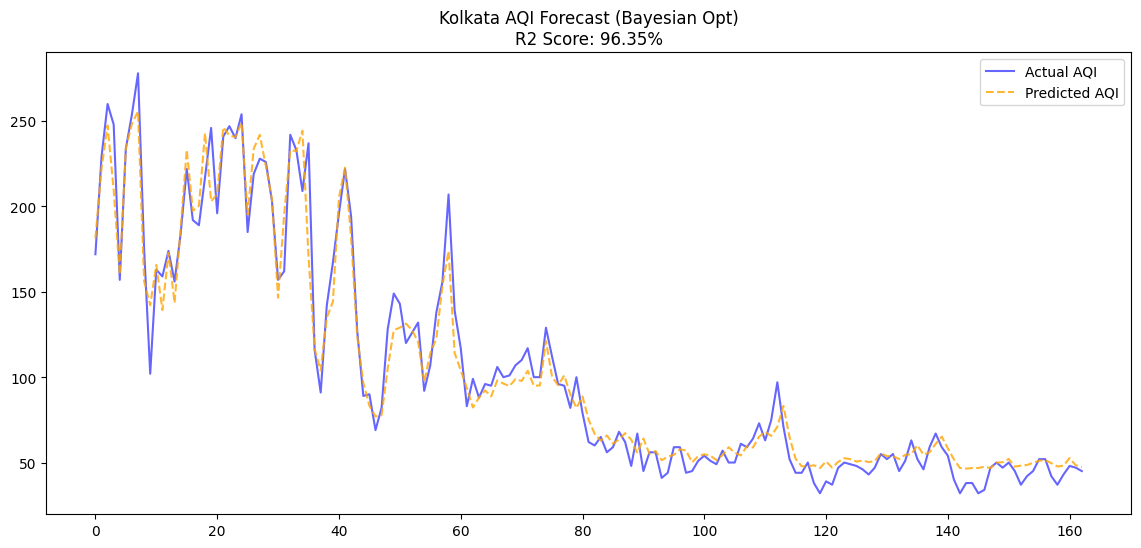

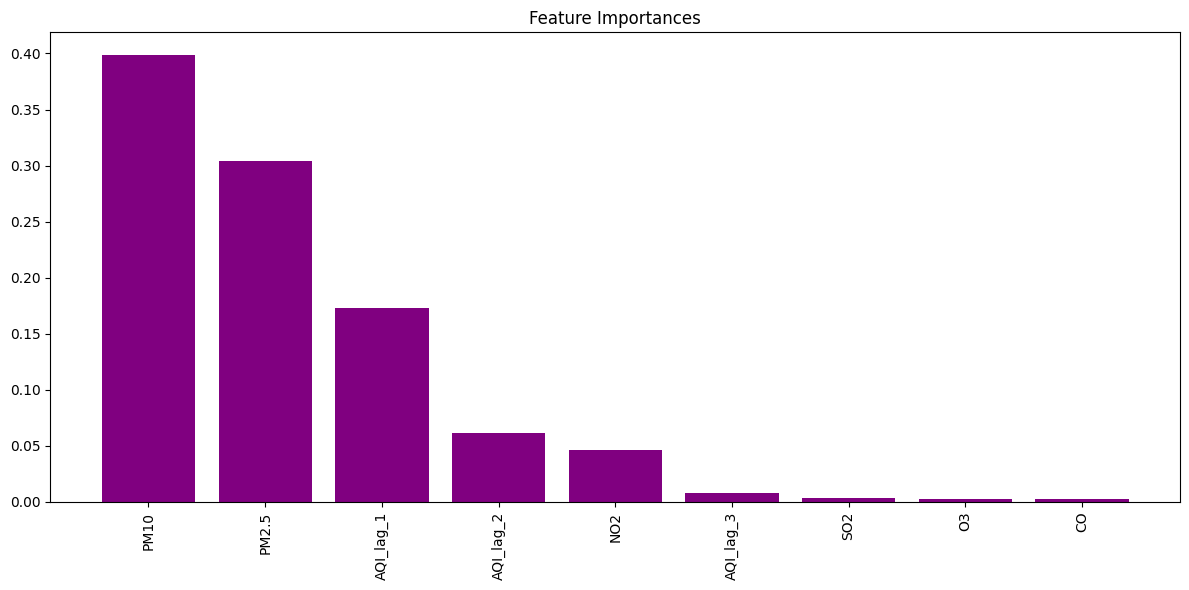


Top Features used by Model:
1. PM10: 0.3989
2. PM2.5: 0.3042
3. AQI_lag_1: 0.1728
4. AQI_lag_2: 0.0615
5. NO2: 0.0460


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# BayesSearchCV ইমপোর্ট করা
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Categorical, Integer
except ImportError:
    print("Error: scikit-optimize ঠিকমতো লোড হয়নি। কার্নেল রিস্টার্ট করে আবার চেষ্টা করো।")

# ---------------------------------------------------------
# 1. Load Data & Preprocessing
# ---------------------------------------------------------
try:
    df = pd.read_csv('city_day.csv/city_day.csv')
except FileNotFoundError:
    print("Error: ফাইল পাওয়া যাচ্ছে না।")

# Kolkata ফিল্টার করা
kolkata_df = df[df['City'] == 'Kolkata'].copy()
kolkata_df['Date'] = pd.to_datetime(kolkata_df['Date'])
kolkata_df = kolkata_df.sort_values('Date')

# মিসিং ভ্যালু হ্যান্ডলিং
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'O3', 'AQI']
for col in features:
    if col in kolkata_df.columns:
        kolkata_df[col] = kolkata_df[col].interpolate(method='linear', limit_direction='both')

# ---------------------------------------------------------
# 2. Feature Engineering (Lags)
# ---------------------------------------------------------
def create_lags(data, target_col, lags=3):
    df_lag = data.copy()
    for i in range(1, lags + 1):
        df_lag[f'{target_col}_lag_{i}'] = df_lag[target_col].shift(i)
    return df_lag.dropna()

df_ml = create_lags(kolkata_df[features], 'AQI', lags=3)

# ---------------------------------------------------------
# 3. Train-Test Split
# ---------------------------------------------------------
train_size = int(len(df_ml) * 0.8)
train, test = df_ml.iloc[:train_size], df_ml.iloc[train_size:]

X_train = train.drop(columns=['AQI'])
y_train = train['AQI']
X_test = test.drop(columns=['AQI'])
y_test = test['AQI']

# ---------------------------------------------------------
# 4. Bayesian Optimization (BayesSearchCV)
# ---------------------------------------------------------
print("Starting Bayesian Hyperparameter Tuning...")


search_spaces = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 20),
    'max_features': Categorical(['sqrt', 'log2'])
}

tscv = TimeSeriesSplit(n_splits=3)
rf = RandomForestRegressor(random_state=42)


bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=search_spaces,
    n_iter=20,     # ২০ বার ট্রাই করবে
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

bayes_search.fit(X_train, y_train)

print(f"\nBest Parameters found: {bayes_search.best_params_}")
print(f"Best Validation Score (R2): {bayes_search.best_score_:.4f}")

best_rf_model = bayes_search.best_estimator_

# ---------------------------------------------------------
# 5. Prediction & Evaluation
# ---------------------------------------------------------
print("Predicting with the best model...")
y_pred = best_rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("-" * 30)
print(f"Final Results (Bayesian Optimized):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2*100:.2f}%")
print("-" * 30)

# ---------------------------------------------------------
# 6. Visualizations
# ---------------------------------------------------------

# Graph 1: Actual vs Predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual AQI', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted AQI', color='orange', linestyle='--', alpha=0.8)
plt.title(f'Kolkata AQI Forecast (Bayesian Opt)\nR2 Score: {r2*100:.2f}%')
plt.legend()
plt.show()

# Graph 2: Feature Importance
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color='purple')
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

print("\nTop Features used by Model:")
for i in range(min(5, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")